<a href="https://colab.research.google.com/github/Tazkia1996/brain-mri-unet/blob/main/UNET_UNET%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using UNet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import pickle

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, LeakyReLU

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Data

In [ ]:
DataPath = '/content/gdrive/MyDrive/MSC_Thesis/lgg-mri-segmentation/kaggle_3m/'

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [ ]:
# print(masks[:10], images[:10])

In [ ]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [ ]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [ ]:
imagePath_df.head()

directory                        images  \
0  TCGA_HT_8111_19980330   TCGA_HT_8111_19980330_6.tif   
1  TCGA_HT_8111_19980330   TCGA_HT_8111_19980330_4.tif   
2  TCGA_HT_8111_19980330  TCGA_HT_8111_19980330_20.tif   
3  TCGA_HT_8111_19980330  TCGA_HT_8111_19980330_11.tif   
4  TCGA_HT_8111_19980330  TCGA_HT_8111_19980330_16.tif   

                               masks  
0   TCGA_HT_8111_19980330_6_mask.tif  
1   TCGA_HT_8111_19980330_4_mask.tif  
2  TCGA_HT_8111_19980330_20_mask.tif  
3  TCGA_HT_8111_19980330_11_mask.tif  
4  TCGA_HT_8111_19980330_16_mask.tif

## Image Shape

In [ ]:
def print_imShape():
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    print("Shape of Images ", image.shape)
    print("Shape of Masks ", mask.shape)

In [ ]:
for i in range(5):
    print_imShape()

Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)


## Plot Images

In [ ]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    fig, axs = plt.subplots(1,3, figsize=[13,15])

    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')

    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')

    plt.grid(False)
    plt.show()

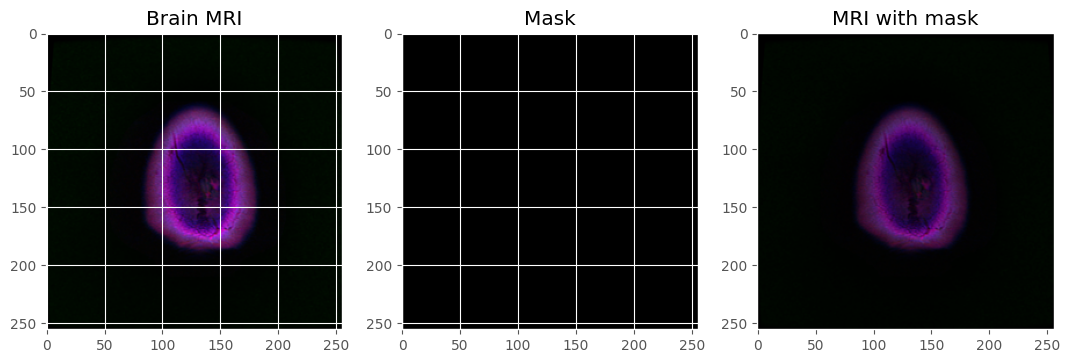

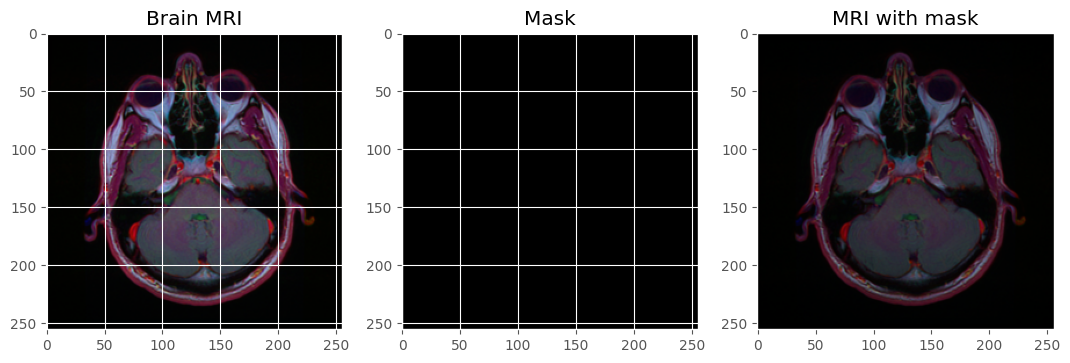

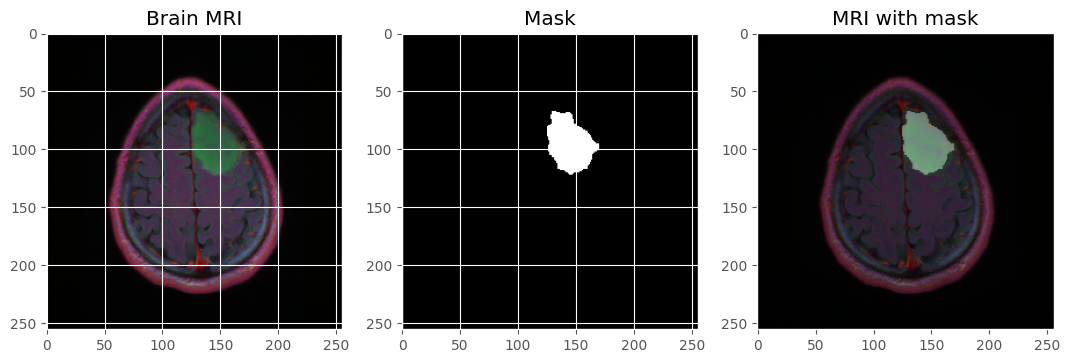

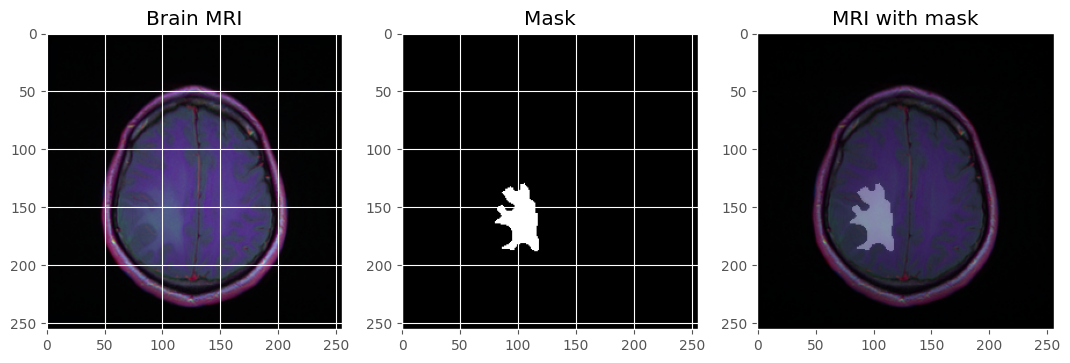

In [ ]:
for i in range(5):
    plot_images()

## Config

In [ ]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks']

In [ ]:
np.random.seed(42)

In [ ]:
train , temp = train_test_split(imagePath_df, test_size=0.3, random_state=21)
test , test2 = train_test_split(temp, test_size=0.333, random_state=21)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 25
ImgHieght = 256
ImgWidth = 256
Channels = 3

## Data Generator

In [ ]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

### Train

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# mask data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 2750 validated image filenames.
Found 2750 validated image filenames.


#**Validation**

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation mask data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 786 validated image filenames.
Found 786 validated image filenames.


#**Test**

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
testimage_generator=imagegen.flow_from_dataframe(dataframe=test2,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation mask data generator
testmask_generator=maskgen.flow_from_dataframe(dataframe=test2,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 393 validated image filenames.
Found 393 validated image filenames.


In [ ]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [ ]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)
test_gen = data_iterator(testimage_generator, testmask_generator)

In [ ]:
# function to create dice coefficient
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)


## UNet

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy", dice_coef])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization_1 (Bat  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 256, 256, 16)         0         ['batch_normalization_1[0]

#**UNET++**

In [ ]:
nb_filter = [16,32,64,128,256]
# Build U-Net++ model
inputs = Input((ImgHieght, ImgWidth, Channels))
drop=0.1
#s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)

conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)
conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)
conv1_3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)

conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)
conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)
conv2_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)
conv1_4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)

'''conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)
conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)
conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)
conv3_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)
conv2_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)
conv1_5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)'''

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_4)

model1 = Model([inputs], [nestnet_output_4])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss,metrics=["accuracy", dice_coef])

In [ ]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 16)         64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_8 (Dropout)         (None, 256, 256, 16)         0         ['batch_normalization_18

In [ ]:
nb_filter = [16,32,64,128,256]
# Build U-Net++ model
inputs = Input((ImgHieght, ImgWidth, Channels))
drop=0.1
#s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)

conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)
conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)
conv1_3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)

conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)
conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)
conv2_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)
conv1_4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)

conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)
conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)
conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)
conv3_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)
conv2_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)
conv1_5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model2 = Model([inputs], [nestnet_output_4])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss,metrics=["accuracy", dice_coef])

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_38 (Ba  (None, 256, 256, 16)         64        ['conv2d_39[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_28 (Dropout)        (None, 256, 256, 16)         0         ['batch_normalization_38

#UNET++L4_LeakyRelu

In [ ]:
nb_filter = [16,32,64,128,256]
# Build U-Net++ model
inputs = Input((ImgHieght, ImgWidth, Channels))
drop=0.1
#s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
c1 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
c2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)
c3 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)

conv3_1 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
conv3_1 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)
conv2_2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)
conv1_3 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)

conv4_1 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
conv4_1 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)
conv3_2 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)
conv2_3 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)
conv1_4 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)

conv5_1 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)
conv5_1 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)
conv4_2 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)
conv3_3 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)
conv2_4 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)
conv1_5 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model3 = Model([inputs], [nestnet_output_4])
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss,metrics=["accuracy", dice_coef])

In [ ]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_68 (Ba  (None, 256, 256, 16)         64        ['conv2d_69[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_58 (Dropout)        (None, 256, 256, 16)         0         ['batch_normalization_68

## Train

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('/content/gdrive/MyDrive/MSC_Thesis/Models/unet.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

callbacks1 = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('/content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL3.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

callbacks2 = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('/content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL4.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

callbacks3 = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('/content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL4leakyrelu.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
import math

STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_TRAIN = int(math.ceil(STEP_SIZE_TRAIN))
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = int(math.ceil(STEP_SIZE_VALID))
STEP_SIZE_TEST = testimage_generator.n/BATCH_SIZE
STEP_SIZE_TEST = int(math.ceil(STEP_SIZE_TEST))

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

110
32
16


#UNET

In [ ]:
results_unet = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: -0.0742 - accuracy: 0.8988 - dice_coef: 0.0742 
Epoch 1: val_loss improved from inf to -0.02257, saving model to /content/gdrive/MyDrive/MSC_Thesis/Models/unet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 3020s 28s/step - loss: -0.0742 - accuracy: 0.8988 - dice_coef: 0.0742 - val_loss: -0.0226 - val_accuracy: 0.1081 - val_dice_coef: 0.0229 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: -0.2112 - accuracy: 0.9809 - dice_coef: 0.2112
Epoch 2: val_loss did not improve from -0.02257
110/110 [==============================] - 54s 496ms/step - loss: -0.2112 - accuracy: 0.9809 - dice_coef: 0.2112 - val_loss: -0.0213 - val_accuracy: 0.1494 - val_dice_coef: 0.0211 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: -0.4746 - accuracy: 0.9905 - dice_coef: 0.4746
Epoch 3: val_loss improved from -0.02257 to -0.39454, saving model to /content/gdrive/MyDrive/MSC_Thesis/Models/unet.h5
110/110 [==============================] - 54s 494ms/step - loss: -0.4746 - accuracy: 0.9905 - dice_coef: 0.4746 - val_loss: -0.3945 - val_accuracy: 0.9793 - val_dice_coef: 0.3920 - lr: 0.0010
Epoch 4/50
110/110 

#UNET++L3

In [ ]:
results_unetplusplusL3 = model1.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks1,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)
# Save the model using Keras's built-in save function
#model.save('/content/gdrive/MyDrive/MSC_Thesis/unet2.h5')


Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: -0.0785 - accuracy: 0.8210 - dice_coef: 0.0785
Epoch 1: val_loss improved from inf to -0.08709, saving model to /content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL3.h5
110/110 [==============================] - 73s 518ms/step - loss: -0.0785 - accuracy: 0.8210 - dice_coef: 0.0785 - val_loss: -0.0871 - val_accuracy: 0.9688 - val_dice_coef: 0.0856 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: -0.1829 - accuracy: 0.9482 - dice_coef: 0.1829
Epoch 2: val_loss improved from -0.08709 to -0.12649, saving model to /content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL3.h5
110/110 [==============================] - 55s 503ms/step - loss: -0.1829 - accuracy: 0.9482 - dice_coef: 0.1829 - val_loss: -0.1265 - val_accuracy: 0.9906 - val_dice_coef: 0.1254 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: -0.4020 - accuracy: 0.9830 - dice_coef: 0.4020
Epoch 3: val_los

#UNET++L4

In [ ]:
results_unetplusplusL4 = model2.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks2,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)
# Save the model using Keras's built-in save function
#model.save('/content/gdrive/MyDrive/MSC_Thesis/unet2.h5')


Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: -0.0840 - accuracy: 0.8329 - dice_coef: 0.0840
Epoch 1: val_loss improved from inf to -0.06756, saving model to /content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL4.h5
110/110 [==============================] - 80s 531ms/step - loss: -0.0840 - accuracy: 0.8329 - dice_coef: 0.0840 - val_loss: -0.0676 - val_accuracy: 0.7356 - val_dice_coef: 0.0668 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: -0.1961 - accuracy: 0.9493 - dice_coef: 0.1961
Epoch 2: val_loss did not improve from -0.06756
110/110 [==============================] - 56s 509ms/step - loss: -0.1961 - accuracy: 0.9493 - dice_coef: 0.1961 - val_loss: -0.0362 - val_accuracy: 0.4984 - val_dice_coef: 0.0362 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: -0.4026 - accuracy: 0.9833 - dice_coef: 0.4026
Epoch 3: val_loss did not improve from -0.06756
110/110 [==============================] - 55s

#UNET++L4LeakyRelu

In [ ]:
results_unetplusplusL4leakyrelu = model3.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks3,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: -0.0703 - accuracy: 0.8033 - dice_coef: 0.0703
Epoch 1: val_loss improved from inf to -0.06494, saving model to /content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL4leakyrelu.h5
110/110 [==============================] - 81s 529ms/step - loss: -0.0703 - accuracy: 0.8033 - dice_coef: 0.0703 - val_loss: -0.0649 - val_accuracy: 0.7077 - val_dice_coef: 0.0650 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: -0.1721 - accuracy: 0.9392 - dice_coef: 0.1721
Epoch 2: val_loss did not improve from -0.06494
110/110 [==============================] - 55s 506ms/step - loss: -0.1721 - accuracy: 0.9392 - dice_coef: 0.1721 - val_loss: -0.0608 - val_accuracy: 0.9126 - val_dice_coef: 0.0611 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: -0.4038 - accuracy: 0.9818 - dice_coef: 0.4038
Epoch 3: val_loss improved from -0.06494 to -0.10200, saving model to /content/gdrive

#Validation Loss

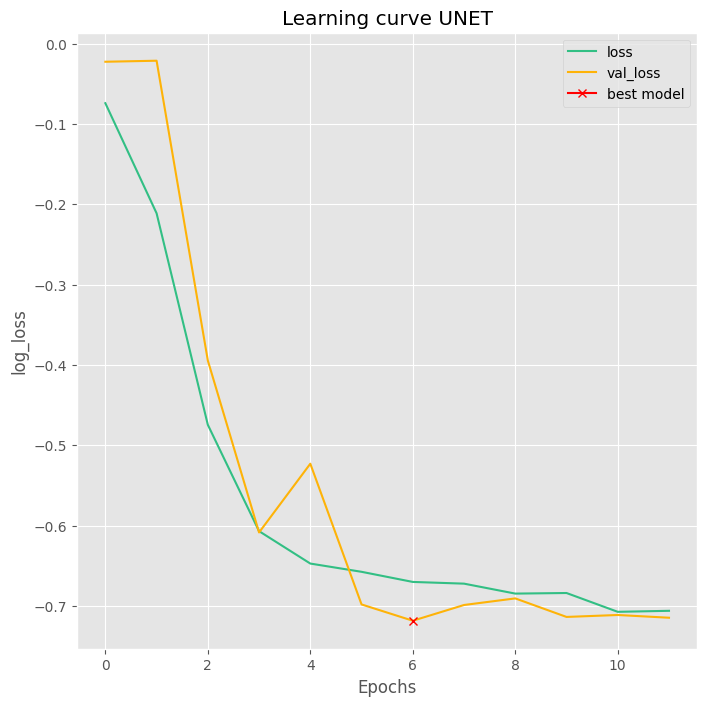

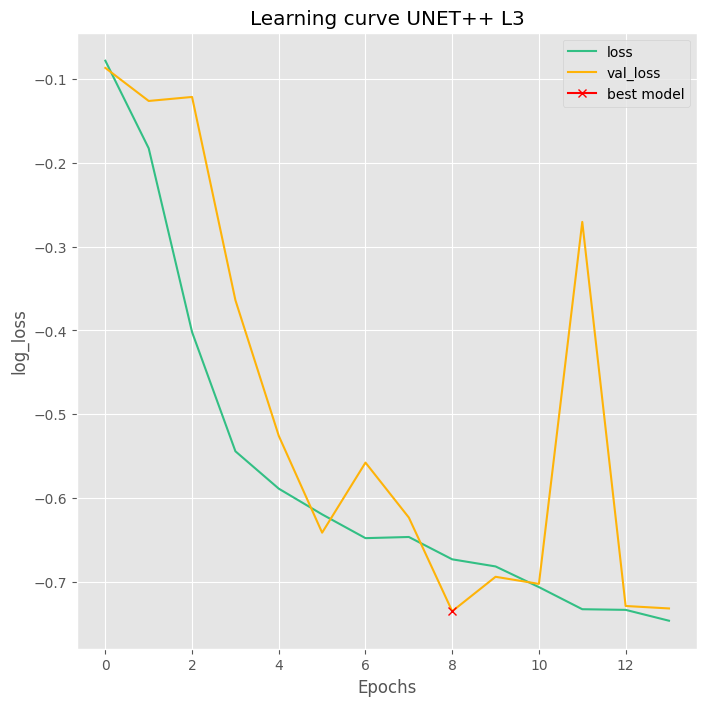

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve UNET")
plt.plot(results_unet.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results_unet.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results_unet.history["val_loss"]), np.min(results_unet.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()


plt.figure(figsize=(8, 8))
plt.title("Learning curve UNET++ L3")
plt.plot(results_unetplusplusL3.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results_unetplusplusL3.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results_unetplusplusL3.history["val_loss"]), np.min(results_unetplusplusL3.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Learning curve UNET++ L4")
plt.plot(results_unetplusplusL4.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results_unetplusplusL4.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results_unetplusplusL4.history["val_loss"]), np.min(results_unetplusplusL4.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

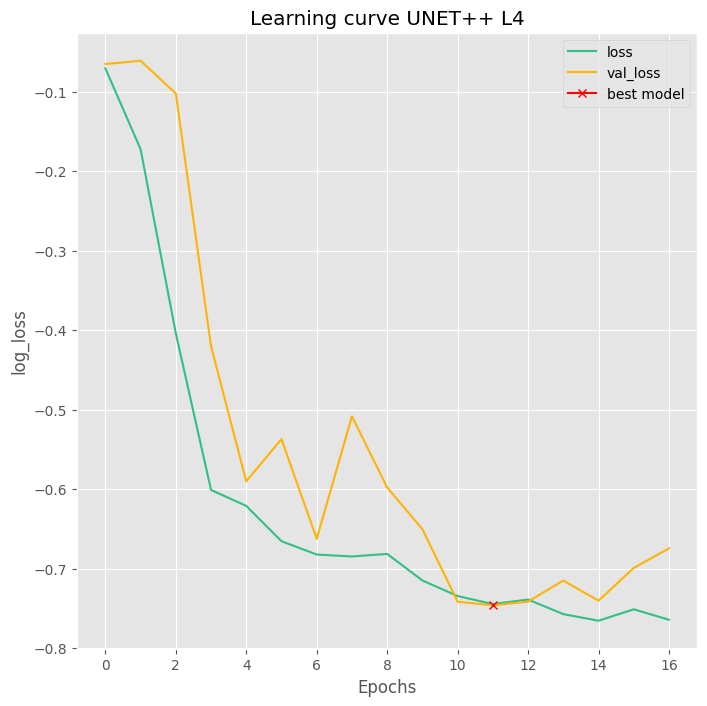

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve UNET++ L4")
plt.plot(results_unetplusplusL4leakyrelu.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results_unetplusplusL4leakyrelu.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results_unetplusplusL4leakyrelu.history["val_loss"]), np.min(results_unetplusplusL4leakyrelu.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

## Prediction

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
unet = load_model('/content/gdrive/MyDrive/MSC_Thesis/Models/unet.h5', custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})
unetplusplusL3 = load_model('/content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL3.h5', custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})
unetplusplusL4 = load_model('/content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL4.h5', custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})
unetplusplusL4_2 = load_model('/content/gdrive/MyDrive/MSC_Thesis/Models/unetplusL4leakyrelu.h5', custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})


# Now, best_model contains the loaded model with the best weights.

#**UNET**

In [ ]:
eval_results1 = unet.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

print("Valid Loss: ", eval_results1[0])
print("Valid Accuracy: ", eval_results1[1])
print("Valid Dice: ", eval_results1[2])

32/32 [==============================] - 4s 102ms/step - loss: -0.7123 - accuracy: 0.9946 - dice_coef: 0.7132
Valid Loss:  -0.7123423218727112
Valid Accuracy:  0.9946237206459045
Valid Dice:  0.7132274508476257


In [ ]:
eval_results2 = unet.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)

print("Test Loss: ", eval_results2[0])
print("Test Accuracy: ", eval_results2[1])
print("Test Dice: ", eval_results2[2])

16/16 [==============================] - 320s 21s/step - loss: -0.7623 - accuracy: 0.9953 - dice_coef: 0.7633
Test Loss:  -0.7623273134231567
Test Accuracy:  0.9952579140663147
Test Dice:  0.7633234262466431


#UNET++L3

In [ ]:
eval_results3 = unetplusplusL3.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

print("Valid Loss: ", eval_results3[0])
print("Valid Accuracy: ", eval_results3[1])
print("Valid Dice: ", eval_results3[2])

32/32 [==============================] - 4s 105ms/step - loss: -0.7082 - accuracy: 0.9946 - dice_coef: 0.7032
Valid Loss:  -0.7081680297851562
Valid Accuracy:  0.9946119785308838
Valid Dice:  0.703199028968811


In [ ]:
eval_results4 = unetplusplusL3.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)

print("Test Loss: ", eval_results4[0])
print("Test Accuracy: ", eval_results4[1])
print("Test Dice: ", eval_results4[2])

16/16 [==============================] - 2s 150ms/step - loss: -0.7681 - accuracy: 0.9948 - dice_coef: 0.7700
Test Loss:  -0.7680789232254028
Test Accuracy:  0.9947569370269775
Test Dice:  0.7700148820877075


#**UNET**++L4

In [ ]:
eval_results5 = unetplusplusL4.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

print("Valid Loss: ", eval_results5[0])
print("Valid Accuracy: ", eval_results5[1])
print("Valid Dice: ", eval_results5[2])

32/32 [==============================] - 5s 104ms/step - loss: -0.8410 - accuracy: 0.9971 - dice_coef: 0.8414
Valid Loss:  -0.8410268425941467
Valid Accuracy:  0.9970895051956177
Valid Dice:  0.8413898944854736


In [ ]:
eval_results6 = unetplusplusL4.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)

print("Test Loss: ", eval_results6[0])
print("Test Accuracy: ", eval_results6[1])
print("Test Dice: ", eval_results6[2])

16/16 [==============================] - 2s 118ms/step - loss: -0.8537 - accuracy: 0.9971 - dice_coef: 0.8542
Test Loss:  -0.8536620736122131
Test Accuracy:  0.9971402287483215
Test Dice:  0.854206919670105


## UNET++L4_LeakyRelu

In [ ]:
eval_results7 = unetplusplusL4_2.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

print("Valid Loss: ", eval_results7[0])
print("Valid Accuracy: ", eval_results7[1])
print("Valid Dice: ", eval_results7[2])

32/32 [==============================] - 4s 110ms/step - loss: -0.7404 - accuracy: 0.9947 - dice_coef: 0.7428
Valid Loss:  -0.7403507232666016
Valid Accuracy:  0.9946820139884949
Valid Dice:  0.7427992224693298


In [ ]:
eval_results8 = unetplusplusL4_2.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)

print("Test Loss: ", eval_results8[0])
print("Test Accuracy: ", eval_results8[1])
print("Test Dice: ", eval_results8[2])

16/16 [==============================] - 2s 156ms/step - loss: -0.7733 - accuracy: 0.9960 - dice_coef: 0.7727
Test Loss:  -0.7732838988304138
Test Accuracy:  0.9960175156593323
Test Dice:  0.7726536989212036


1/1 [==============================] - 0s 498ms/step


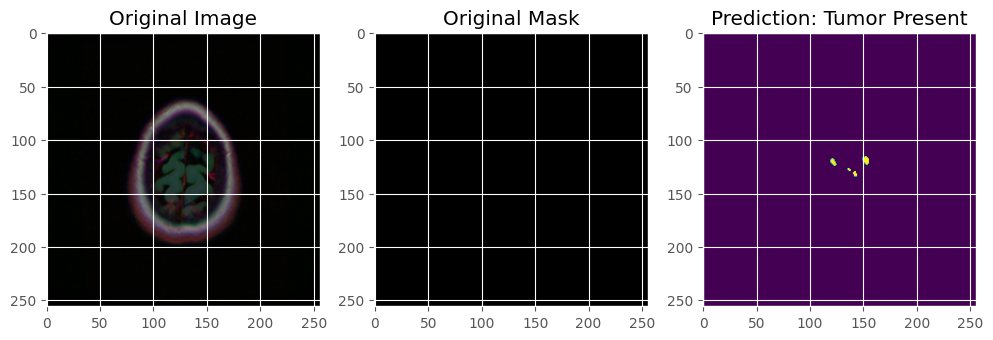

1/1 [==============================] - 0s 20ms/step


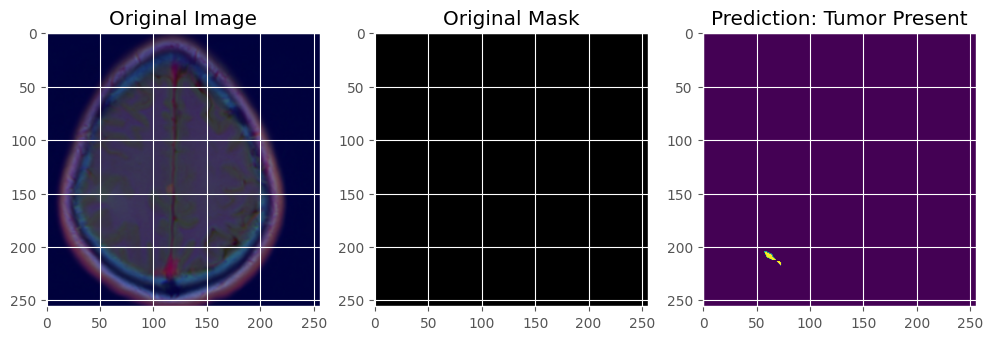

1/1 [==============================] - 0s 20ms/step


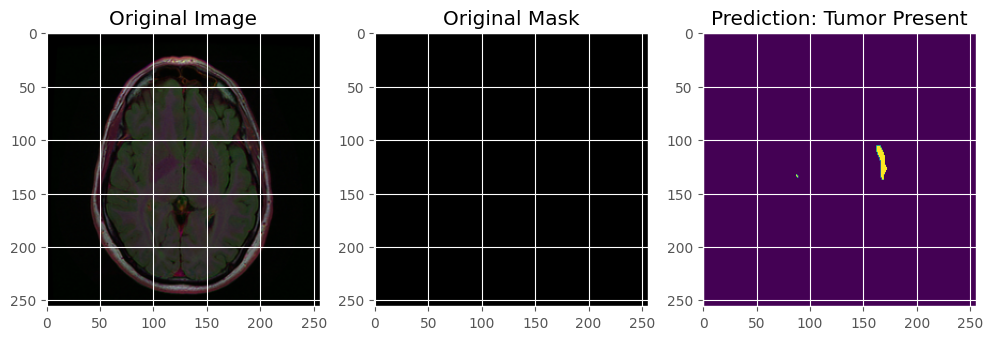

1/1 [==============================] - 0s 20ms/step


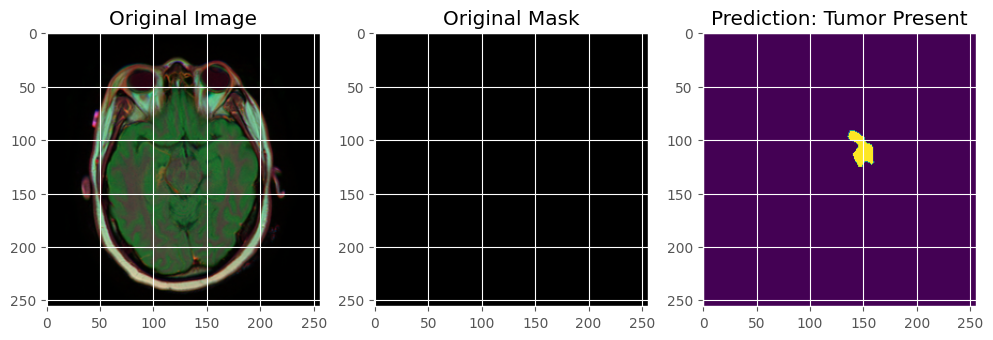

1/1 [==============================] - 0s 18ms/step


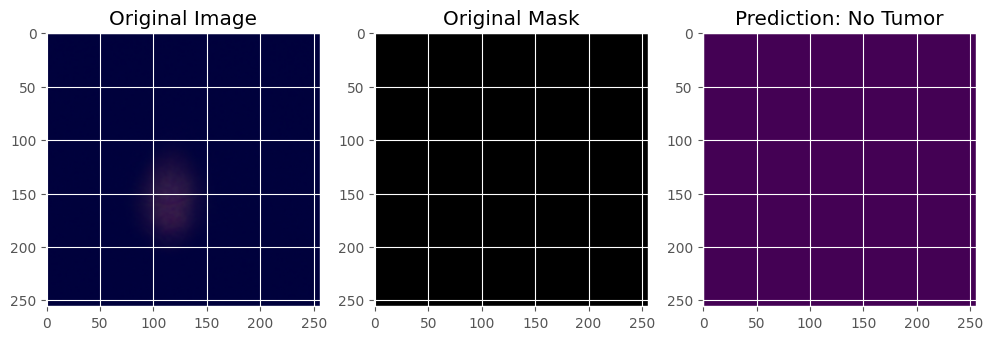

1/1 [==============================] - 0s 18ms/step


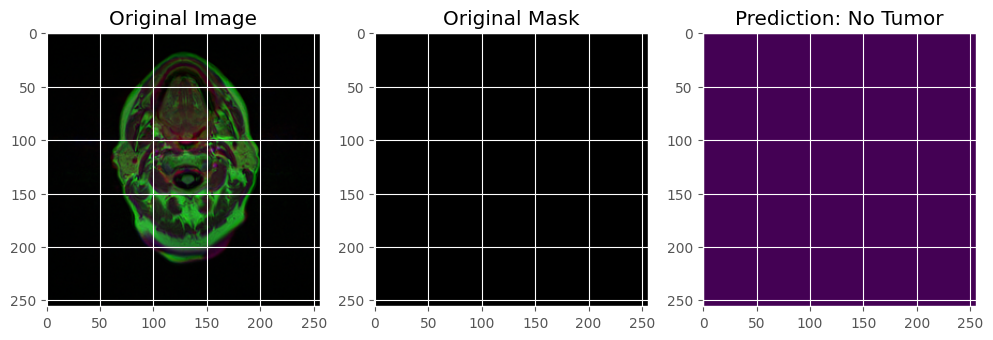

1/1 [==============================] - 0s 20ms/step


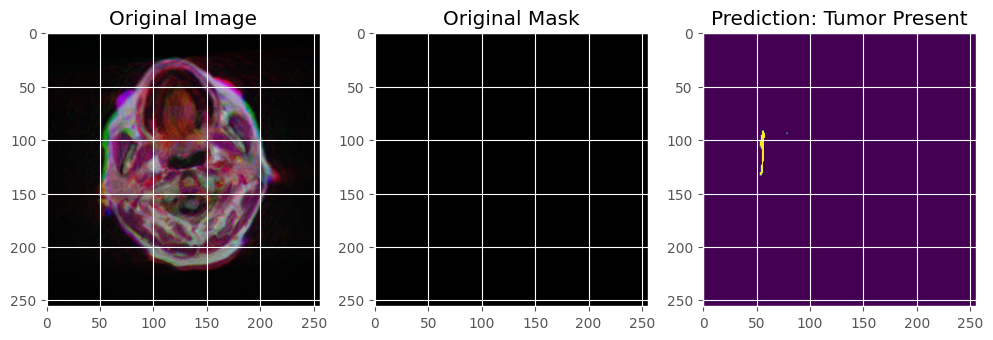

1/1 [==============================] - 0s 20ms/step


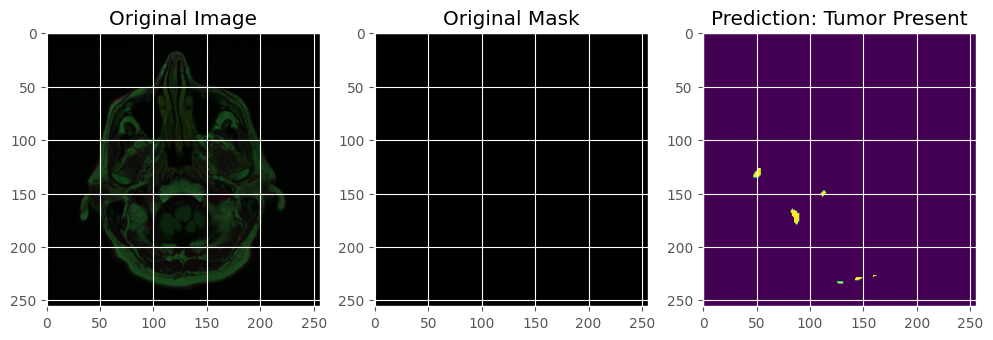

1/1 [==============================] - 0s 22ms/step


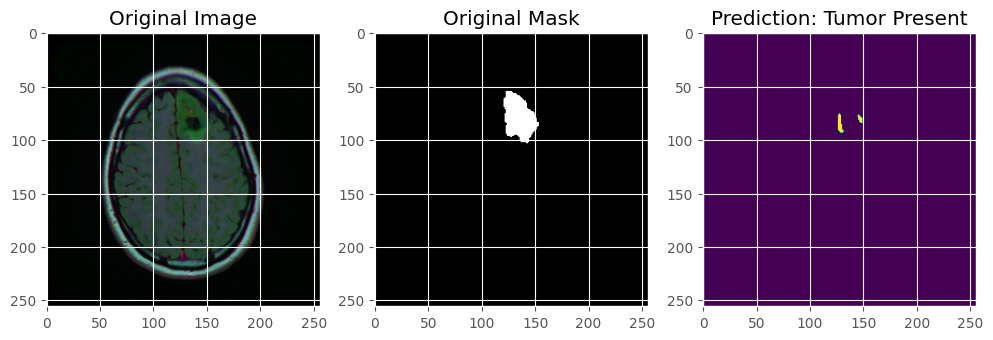

1/1 [==============================] - 0s 20ms/step


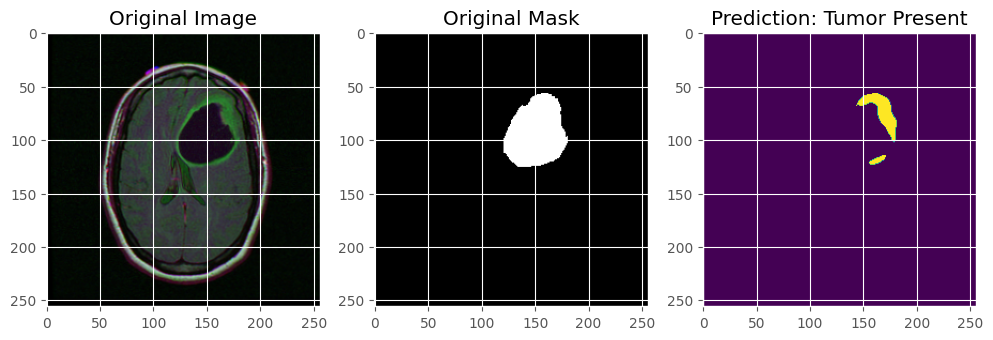

In [ ]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=unet.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    if (np.squeeze(pred) > 0.5).any():
      label = "Prediction: Tumor Present"
    else:
      label = "Prediction: No Tumor"
    plt.title(label)
    plt.show()

1/1 [==============================] - 1s 704ms/step


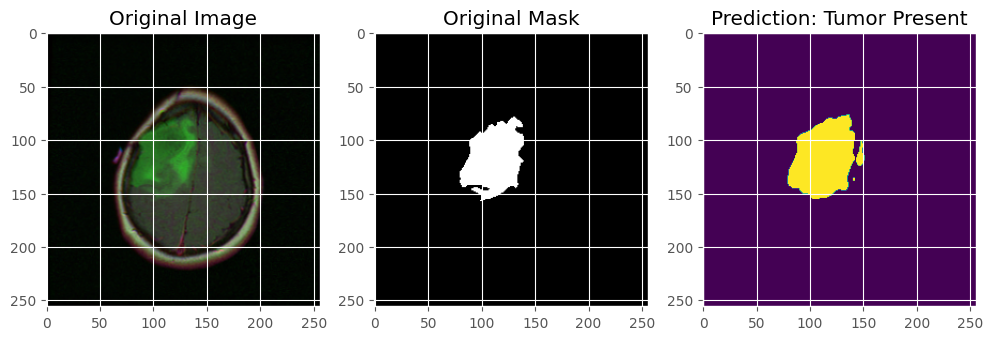

1/1 [==============================] - 0s 20ms/step


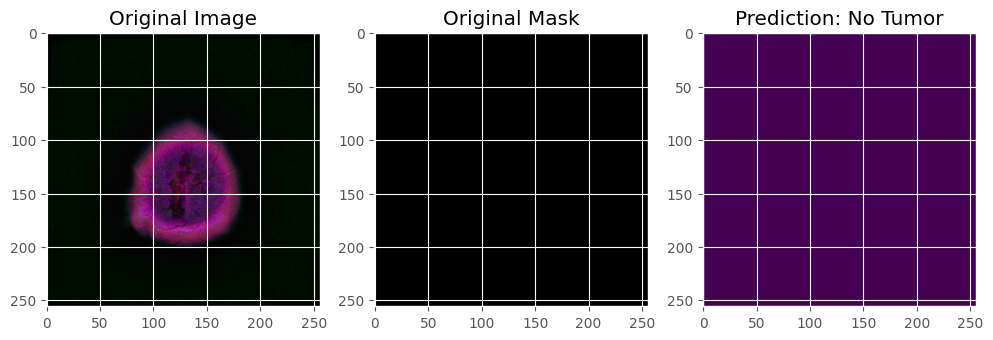

1/1 [==============================] - 0s 20ms/step


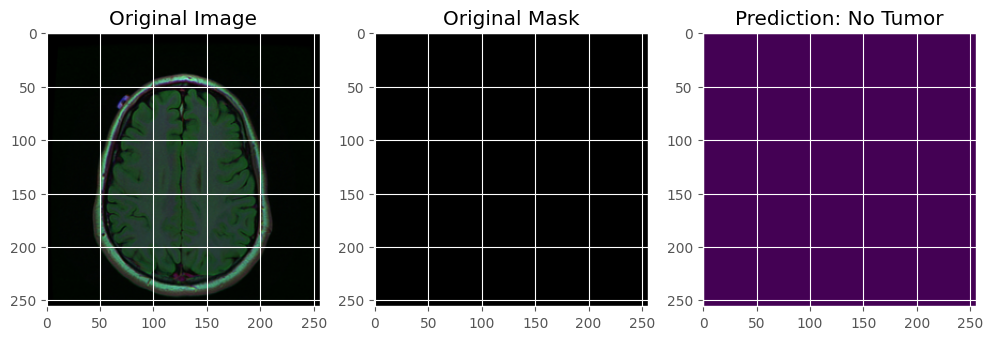

1/1 [==============================] - 0s 22ms/step


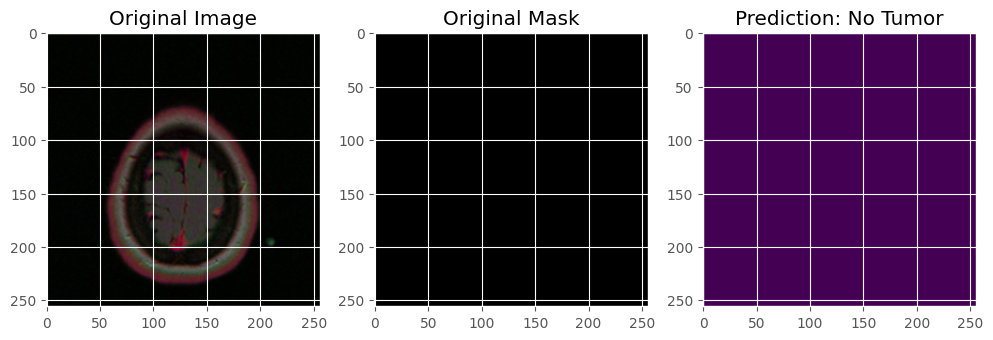

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


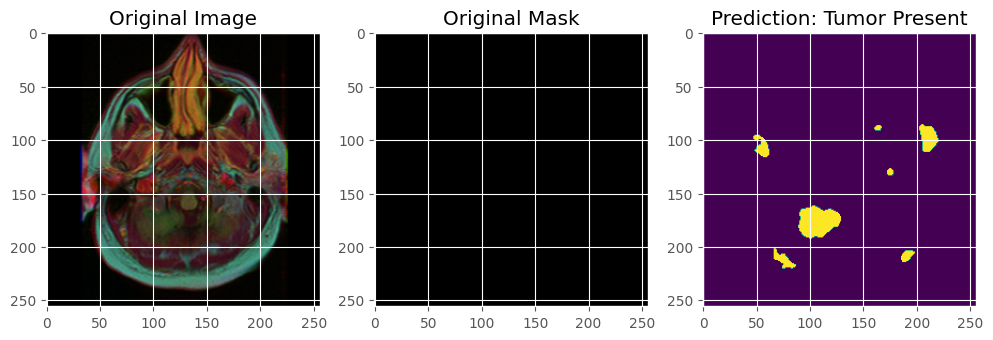

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


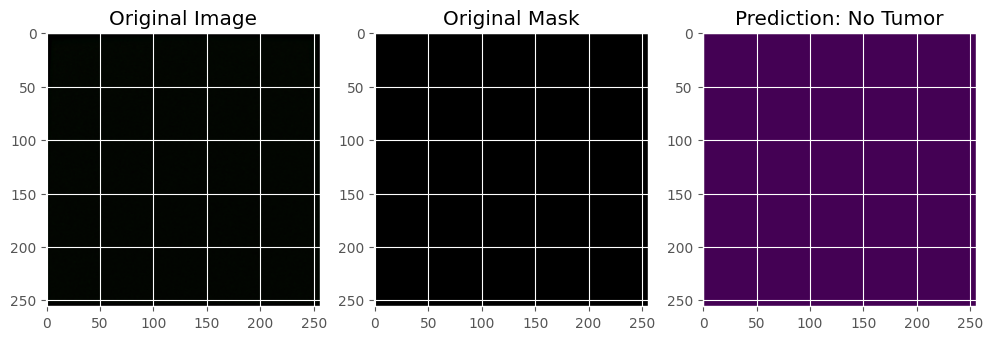

1/1 [==============================] - 0s 21ms/step


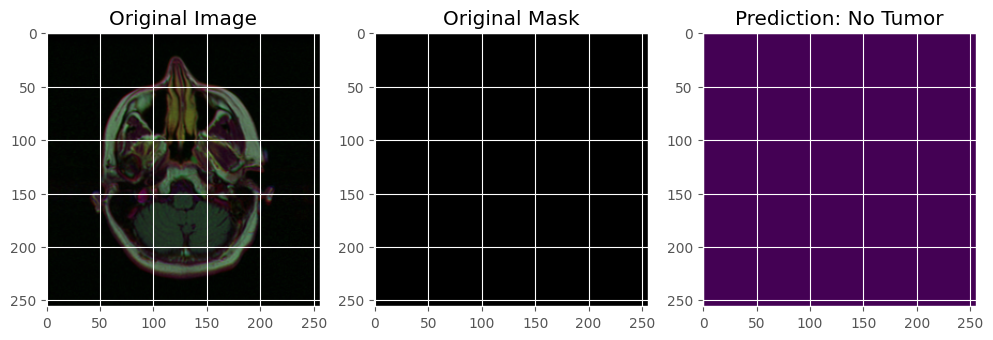

1/1 [==============================] - 0s 20ms/step


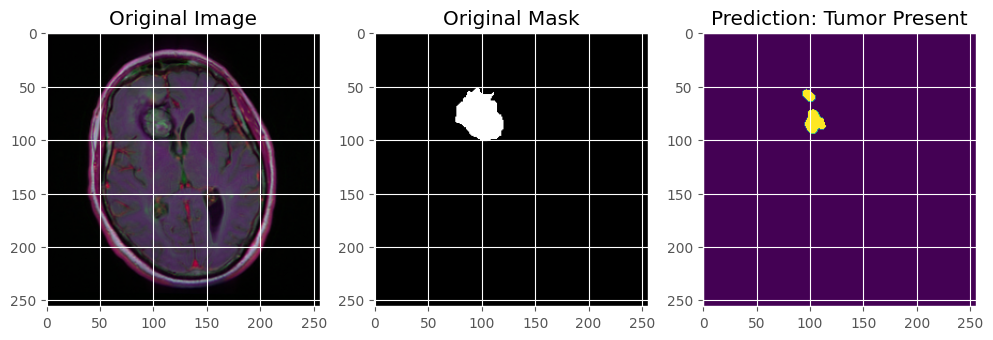

In [ ]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=unetplusplusL3.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    if (np.squeeze(pred) > 0.5).any():
      label = "Prediction: Tumor Present"
    else:
      label = "Prediction: No Tumor"
    plt.title(label)
    plt.show()

1/1 [==============================] - 1s 830ms/step


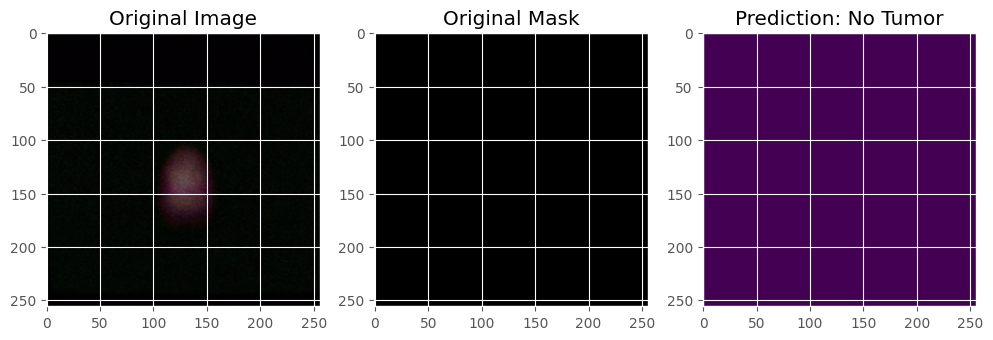

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


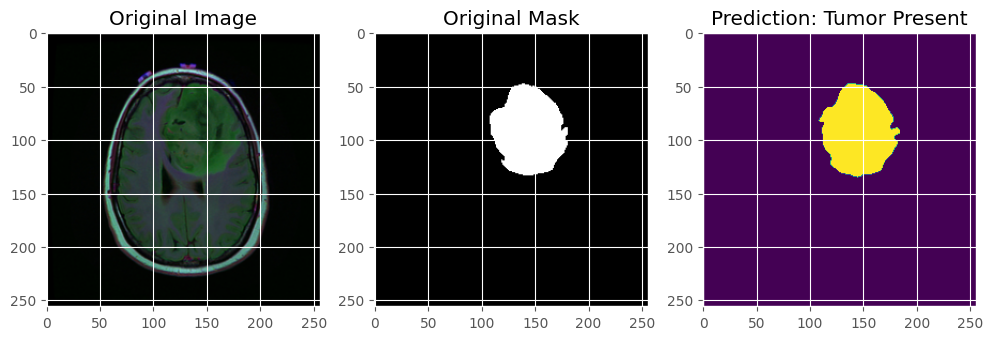

1/1 [==============================] - 0s 22ms/step


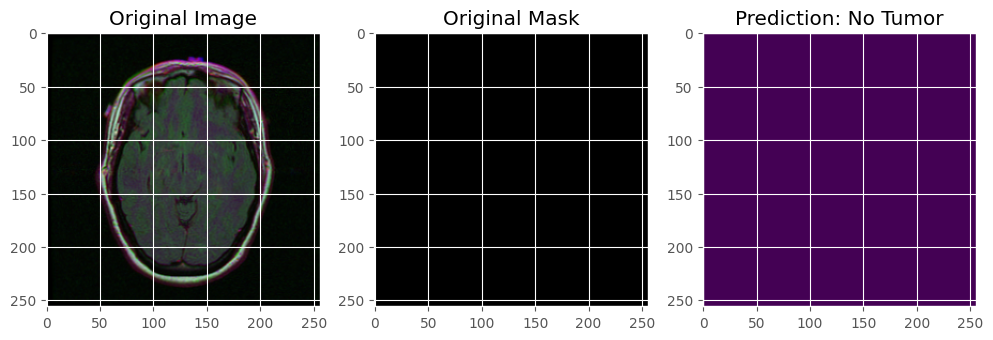

1/1 [==============================] - 0s 21ms/step


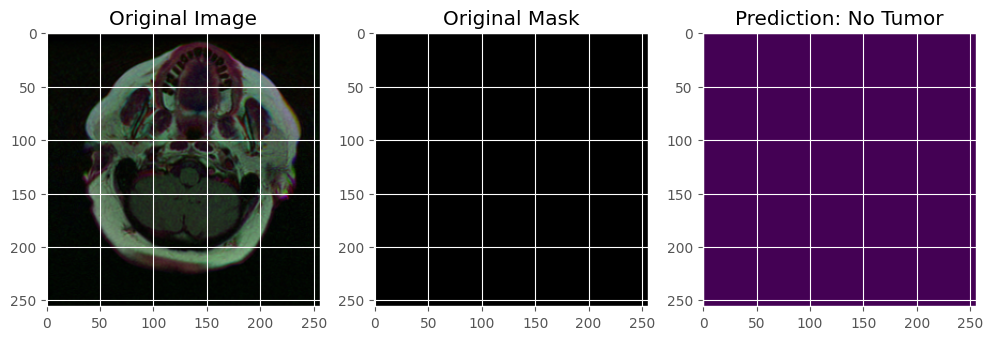

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


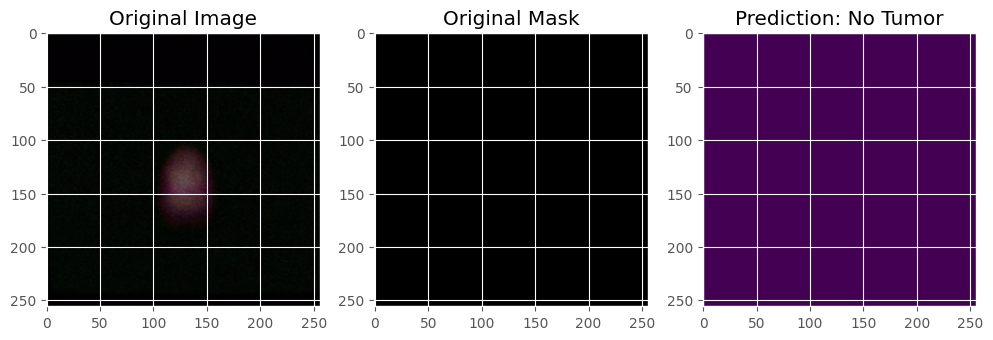

1/1 [==============================] - 0s 23ms/step


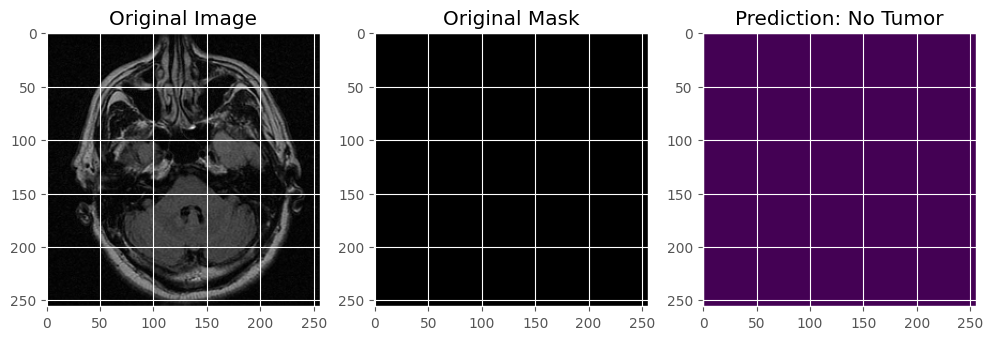

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


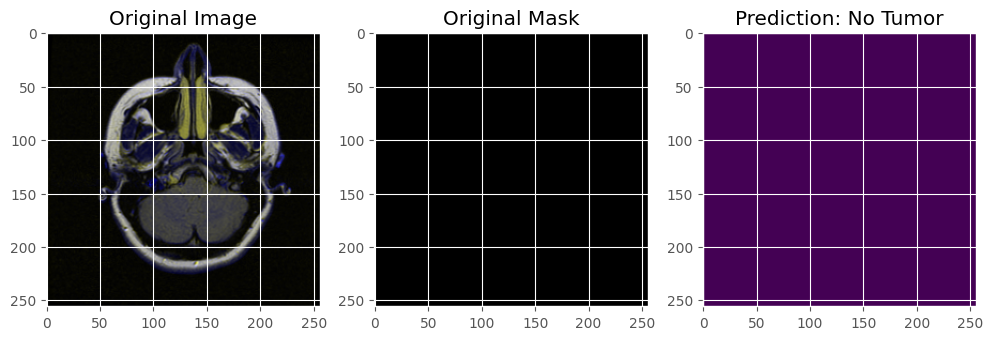

In [ ]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=unetplusplusL4.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    if (np.squeeze(pred) > 0.5).any():
      label = "Prediction: Tumor Present"
    else:
      label = "Prediction: No Tumor"
    plt.title(label)
    plt.show()